<a href="https://colab.research.google.com/github/joshmurr/machine-learnings/blob/master/cci-dsai/ProGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ProGAN - _Progressively Growing GAN_

We are going to be playing with a _pre-trained_ ProGAN which is available on [Tensorflow-Hub](https://www.tensorflow.org/hub) [here](https://tfhub.dev/google/progan-128/1).

This is a modified version of a [this original notebook](https://www.tensorflow.org/hub/tutorials/tf_hub_generative_image_module) from Tensorflow.

Paper: [Progressive Growing of GANs for Improved Quality, Stability, and Variation](https://arxiv.org/abs/1710.10196).

First some packages to install..

In [ ]:
!pip -q install imageio scikit-image
!pip -q install git+https://github.com/tensorflow/docs

And then some helper functions which we will use later on.

In [150]:
import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.random.set_seed(0) # To make results replicatable

import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform

# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512


# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

# Simple way to display an image.
def display_image(image):
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())

# Given a set of images, show an animation.
def animate(images):
  images = np.array(images)
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  return embed.embed_file('./animation.gif')

def image_grid(x, size=6):
  t = tf.unstack(x[:size * size], num=size*size, axis=0)
  rows = [tf.concat(t[i*size:(i+1)*size], axis=0) 
          for i in range(size)]
  image = tf.concat(rows, axis=1)
  return image[None]

# Import the Model using TF-Hub

Importing a pretrained model using TF-hub is easy.

We need to add `.signatures['default']` because the model was added to TF-Hub and made using Tensorflow 1.x, but we are using Tensorflow 2.x. [More information here](https://www.tensorflow.org/hub/common_issues).

In [31]:
progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']

# Generate an Image

To generate an image we first generate a vector of random numbers of the right length that the model expects: 512.

It is then as simple as passing that vector into the model..!

The model returns a tensor of shape `[BatchSize, Width, Height, NumChannels]`. In this case the batch size is one, so we still need to pluck out the one and only image in that batch by selecting `image[0]` and passing that to `display_image()` which is one of our helper functions.

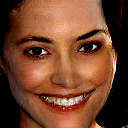

In [151]:
z = tf.random.normal([latent_dim])
image = progan(z)['default']
display_image(image[0])

# Generate a Multiple Images

We can generate multiple images simply by creating a _batch_ of latent vectors and passing those to the ProGAN all at once. Here I am generating 25 latent vectors called `bag_of_zs`.

The model will then return a tensor of shape `[25, Width, Height, NumChannels]`.

`image_grid()` is a helper function which reshapes the tensor of multiple outputs into one of a single output, to make it easier to display as an image.


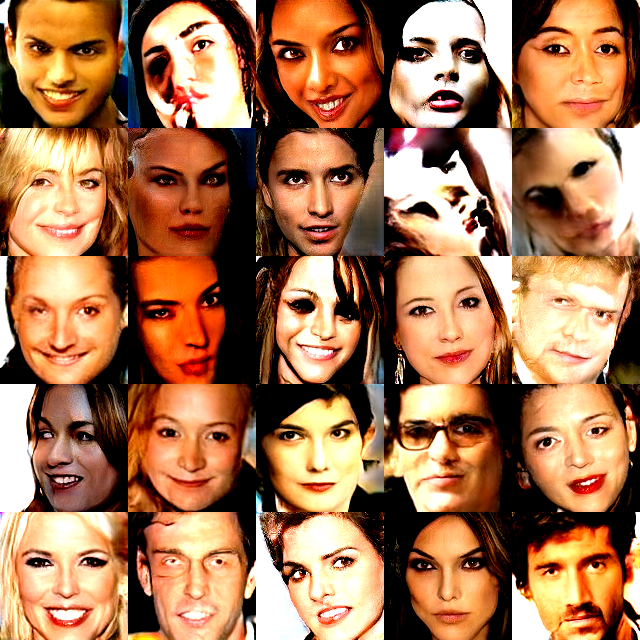

In [172]:
bag_of_zs = tf.random.normal([25, latent_dim])
images = progan(bag_of_zs)['default']
grid = image_grid(images, size=5)

display_image(grid[0])

But the batched tensor output from the model is still in the variable `images`, so if we want to pick out an image from the grid that we particularly like, we can simply select that image in the list like so: `images[n]`.

Note the order is like so:

```
0 6 . 
1 7 .
2 8 .
3 . .
4 . . 
5 .
```

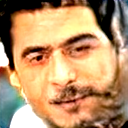

In [154]:
display_image(images[1])

# Interpolating Between Vectors

Interpolating between vectors is also very easy! First we have a helper function below which does a fancier interpolation across the _hypersphere_ that is our latent space. This will generate slightly more interesting results than a simple _linear interpolation_.

Look inside the function and you'll see it just generates another bag of vectors, this time the interpolated points, and then passes this as a list into the ProGAN (which will return a batch of tensors).

In [147]:
def interpolate_between_vectors(_v1=tf.random.normal([latent_dim]),
                                _v2=tf.random.normal([latent_dim])):
  v1 = _v1 
  v2 = _v2
    
  # Creates a tensor with 25 steps of interpolation between v1 and v2.
  vectors = interpolate_hypersphere(v1, v2, 50)

  # Uses module to generate images from the latent space.
  interpolated_images = progan(vectors)['default']

  return interpolated_images

We can either call the function with _no arguments_ to get a random interpolation like so: `interpolate_between_points()`.




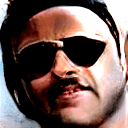

In [171]:
interpolated_images = interpolate_between_vectors()
animate(interpolated_images)

Or we can select vectors from the bag of vectors we generated earlier if we know they produce faces we particularly like.


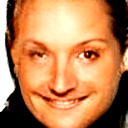

In [173]:
interpolated_images = interpolate_between_vectors(bag_of_zs[2], bag_of_zs[23])
animate(interpolated_images)

# Projecting into Latent Space

To project into latent space we first need an image to project. Run the cell below to upload your own image.

It's interesting to upload something which is not a face to see how the model reacts... I've chosen a debugging image from another project.

Saving Screenshot from 2020-10-08 12-29-00.png to Screenshot from 2020-10-08 12-29-00.png


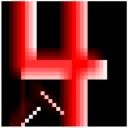

In [175]:
def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])

target_image = upload_image()

display_image(target_image)

Next we need an `initial_vector` to start the process. This is the vector we will be optimising over time to get closer to one which creates an images similar to ours.

We can see what image that vector produces..

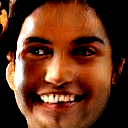

In [176]:
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

Here is the 'training loop' where we optimize the `initial_vector`... You can see it's relatively simple.

In [177]:
def find_closest_latent_vector(initial_vector, num_optimization_steps,
                               steps_per_image):
  images = []
  losses = []

  vector = tf.Variable(initial_vector)  
  optimizer = tf.optimizers.Adam(learning_rate=0.01)
  loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

  for step in range(num_optimization_steps):
    if (step % 100)==0:
      print()
    print('.', end='')
    with tf.GradientTape() as tape:
      image = progan(vector.read_value())['default'][0]
      image = tf.cast(image, dtype=tf.double)
      if (step % steps_per_image) == 0:
        images.append(image.numpy())
      target_image_difference = loss_fn(image, target_image[:,:,:3])
      # The latent vectors were sampled from a normal distribution. We can get
      # more realistic images if we regularize the length of the latent vector to 
      # the average length of vector from this distribution.
      regularizer = tf.cast(tf.abs(tf.norm(vector) - np.sqrt(latent_dim)), dtype=tf.float64)

      loss = target_image_difference + regularizer
      losses.append(loss.numpy())

    # Here we update the optimized vector
    grads = tape.gradient(loss, [vector])
    optimizer.apply_gradients(zip(grads, [vector]))
    
  return images, losses


num_optimization_steps=200
steps_per_image=5
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)


....................................................................................................
....................................................................................................

(0.0, 4630.2668001174925)

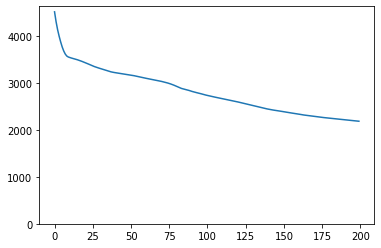

In [178]:
plt.plot(loss)
plt.ylim([0,max(plt.ylim())])


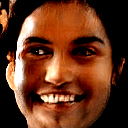

In [179]:
animate(np.stack(images))

Compare the closest image that this model could find, and our target image.

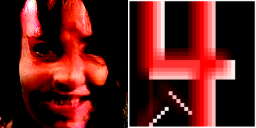

In [180]:
display_image(np.concatenate([images[-1], target_image[:,:,:3]], axis=1))